In [1]:
%pylab inline
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import numba
import cupy as cp
from numba import cuda, prange
from numba.cuda import random
from numba import jit, njit, vectorize
import GPUtil

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Functions
def ReLU(input):
    return input * (input > 0)


# Drift-Diffusion Model

## 1) CPU

Wall time: 6.92 s


<function matplotlib.pyplot.show(close=None, block=None)>

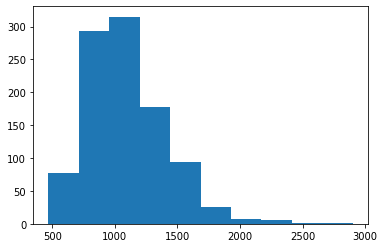

In [7]:
%%time
# DDM

# Variables
coh = 100
rt = np.array([],dtype=float32)       # Accumulator/decision variable
decision = np.array([],dtype=float32)       # Accumulator/decision variable

sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
dr = coh*dg        # drift rate
t = 0              # time -> msec
ndt = 100          # Non-decision time (msec)
bound = 1          # Decision-bound
stop_time = 10000  # Maximum allowed time for simulation
nTrials = 1000     # Number of trials to simulate

diffusion_step = np.random.normal(loc=dr, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
for tr in range(nTrials):
    dv = np.array([sp],dtype=float32)
    for t in range(stop_time):
        dv = np.append(dv, dv[t]+diffusion_step[tr,t])    # update decision variable
        if np.abs(dv[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, np.sign(dv[t]))
            rt =  np.append(rt, t)
            break
            
else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 

    
rt = rt+ndt
    
# plt.plot(rt)
plt.hist(rt)
plt.show


## 2) CPU Parallelization with Numba

Wall time: 276 ms


<function matplotlib.pyplot.show(close=None, block=None)>

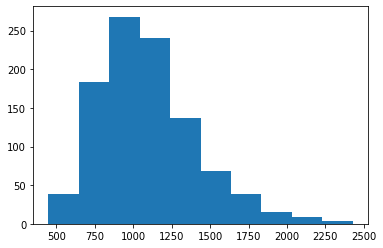

In [5]:
# DDM_jit

@njit(parallel=True,fastmath=True)
def DDM_cpu_parallel(coh,nTrials,pars,stop_time):
    # To create empty array with numba => [np.int64(x) for x in range(0)]
    rt =  np.empty(nTrials)*np.NaN        
    decision = np.empty(nTrials)*np.NaN   
    sp = pars[0]             # starting point 1
    dg = pars[1]             # drift gain
    sigma = pars[2]          # diffusion variability
    ndt = pars[3]            # Non-decision time (msec)
    bound = pars[4]
    dr = coh*dg              # drift rate
    t = 0                    # time -> msec
    
    diffusion_step = np.random.normal(loc=dr, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
    for tr in prange(nTrials):
        dv = np.array([sp],dtype=float64)
        for t in range(stop_time):
            dv = np.append(dv, dv[t]+diffusion_step[tr,t])    # update decision variable
            if np.abs(dv[t]) > bound:    # checking if decision bound is reached
                decision[tr] =  np.sign(dv[t])
                rt[tr] = t
                break
    rt = rt+ndt
    return decision, rt

# DDM_jit_parallel_numba = njit(parallel=True,fastmath=True)(DDM_numba)
# Initializing jit compilation
coh = 100
sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
dr = coh*dg        # drift rate
t = 0              # time -> msec
ndt = 100          # Non-decision time (msec)
bound = 1          # Decision-bound
stop_time = 1000   # Maximum allowed time for simulation
nTrials = 10       # Number of trials to simulate
pars = np.array([sp,dg,sigma,ndt,bound])
DDM_cpu_parallel(coh,nTrials,pars,stop_time) 


# Variables
coh = 100
sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
dr = coh*dg        # drift rate
t = 0              # time -> msec
ndt = 100          # Non-decision time (msec)
bound = 1          # Decision-bound
stop_time = 10000  # Maximum allowed time for simulation
nTrials = 1000     # Number of trials to simulate
pars = np.array([sp,dg,sigma,ndt,bound])
%time decision, rt = DDM_cpu_parallel(coh,nTrials,pars,stop_time)

# plt.plot(rt)
plt.hist(rt)
plt.show

## 3) GPU Parallelization with Numba and CuPy

#### DDM Kernel for Numba

In [21]:
# @jit
def get_diffusion_matrix(coherence, drift_gain, sigma, nTrials=50000, stop_time=10000):
    # Check if coherence value is scalar. If it is, then create matrix for diffusion step calculation
    if np.isscalar(coherence):        
        coherence = np.ones((nTrials, stop_time), dtype=float32)*coherence

#     if 'diffusion_matrix' in globals():  # If diffusion_matrix is already defined delete it to reduce load on VRAM
#         del diffusion_matrix
#         cp.get_default_memory_pool().free_all_blocks()
    diffusion_matrix = cp.asarray(coherence)
    diffusion_matrix = cp.multiply(diffusion_matrix,cp.asarray(drift_gain))    # Mean of diffusion to be Coh x drift gain
    diffusion_matrix = cp.random.normal(diffusion_matrix, sigma, dtype='float32')    # Generating normal random steps
#     GPUtil.showUtilization()
    return diffusion_matrix

# For Dynamic Coherence
@cuda.jit
def DDM_kernel(sp, bound, ndt, diffusion_step, decision, rt): 
    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (diffusion_step.shape[0] - 1))   
    if tr_in_bounds:
        dv = sp
        for t in range(diffusion_step.shape[1]):
            dv = dv + diffusion_step[tr,t]      # update decision variable
            if dv > bound or dv < -bound:       # checking if decision bound is reached
                decision[tr] =  2*(dv>0) - 1    # np.sign(dv) alternative
                rt[tr] = t+ndt
                break  
# Initializing DDM_Coherence_kernel with small variables
sp=0
ndt=0
bound=1
diffusion_step = cp.array([[2,3],[3,5]])
decision = cp.empty(2)*cp.NaN
rt = cp.empty(2)*cp.NaN
blockdim = (16)
griddim = (diffusion_step.shape[0] // blockdim) + 1
cuda.synchronize()
%time DDM_kernel[griddim, blockdim](sp, bound, ndt, diffusion_step, decision, rt)
cuda.synchronize()


Wall time: 138 ms


C:\Users\mablab\anaconda3\envs\Decision-Models\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (40) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Wall time: 2.35 s
Wall time: 165 ms


(array([2.1180e+03, 1.6167e+04, 1.8080e+04, 9.1180e+03, 3.2600e+03,
        9.1300e+02, 2.7100e+02, 5.5000e+01, 1.4000e+01, 4.0000e+00]),
 array([ 365.,  663.,  961., 1259., 1557., 1855., 2153., 2451., 2749.,
        3047., 3345.]),
 <BarContainer object of 10 artists>)

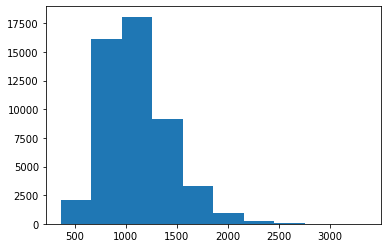

In [22]:
# %%time
cp.random.seed()
coh = 100
sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
ndt = 100          # Non-decision time (msec)
bound = 1
dg = np.array([dg],dtype=float32)

coherence = np.ones((50000, 10000), dtype=float32)*coh
%time diffusion_matrix = get_diffusion_matrix(coh, dg, sigma)
decision = cp.empty(diffusion_matrix.shape[0])*cp.NaN
rt = cp.empty(diffusion_matrix.shape[0])*cp.NaN
blockdim = (16)
griddim = (diffusion_matrix.shape[0] // blockdim) + 1
cuda.synchronize()
%time DDM_kernel[griddim, blockdim](sp, bound, ndt, diffusion_matrix, decision, rt)
cuda.synchronize()

decision = cp.asnumpy(decision)
rt = cp.asnumpy(rt)
plt.hist(rt)


### DDM Cuda kernel with inbuilt diffusion step

In [142]:

# For Dynamic Coherence
@cuda.jit
def DDM_kernel_for_delay(coherence, sp, dg, sigma, bound, ndt, decision, rt, rng_states): 
    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (coherence.shape[0] - 1))   
    if tr_in_bounds:
        dv = sp                
        for t in range(coherence.shape[1]):
            diffusion = (coherence[tr,t]*dg)+ (random.xoroshiro128p_normal_float32(rng_states, tr)*sigma)   
            dv = dv + diffusion      # update decision variable
            if dv > bound or dv < -bound:       # checking if decision bound is reached
                decision[tr] =  2*(dv>0) - 1    # np.sign(dv) alternative
                rt[tr] = t+ndt
                break  
                
# Initializing DDM_Coherence_kernel with small variables
sp=0
dg = 10e-6
sigma = 10e-3
ndt=0
bound=1
coherence = cp.array([[100,100],[100,100]])
decision = cp.empty(coherence.shape[0])*cp.NaN
rt = cp.empty(coherence.shape[0])*cp.NaN
blockdim = (16)
griddim = (coherence.shape[0] // blockdim) + 1
rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=1)
cuda.synchronize()
%time DDM_kernel[griddim, blockdim](coherence, sp, dg, sigma, bound, ndt, decision, rt, rng_states)
cuda.synchronize()

Wall time: 3.02 ms


C:\Users\mablab\anaconda3\envs\Decision-Models\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (40) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [147]:
cp.random.seed()
coh = 100
sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
ndt = 100          # Non-decision time (msec)
bound = 1
# dg = np.array([dg],dtype=float32)

if 'coherence' in globals():
    del coherence
coherence = cp.ones((10000, 10000), dtype=float32)*coh


Wall time: 12 ms


(array([ 573., 2666., 3316., 2010.,  921.,  349.,  114.,   34.,   13.,
           4.]),
 array([ 434. ,  683.5,  933. , 1182.5, 1432. , 1681.5, 1931. , 2180.5,
        2430. , 2679.5, 2929. ]),
 <BarContainer object of 10 artists>)

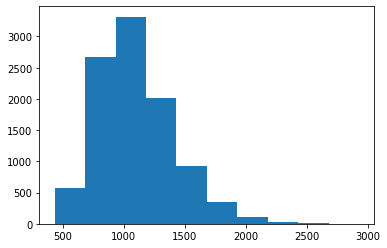

In [148]:

def batch_simulation_delay(model, coherence, sp, dg, sigma, bound, ndt, seed=None):
    batch_size = 10000;
    rt_np = []
    decision_np = []
    blockdim = int(128)
    griddim = (batch_size // blockdim) + 1
    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=seed)

    for i in range((coherence.shape[0]//batch_size)+1):
        coherence_batch = coherence[batch_size*i:batch_size*(i+1)]
        decision_cp = cp.empty(coherence_batch.shape[0])*cp.NaN
        rt_cp = cp.empty(coherence_batch.shape[0])*cp.NaN
        cuda.synchronize()
        model[griddim, blockdim](coherence_batch, sp, dg, sigma, bound, ndt, decision_cp, rt_cp, rng_states);
        cuda.synchronize()
        decision_np = np.append(decision_np, cp.asnumpy(decision_cp))
        rt_np = np.append(rt_np, cp.asnumpy(rt_cp))
    return decision_np, rt_np

%time decision, rt =  batch_simulation_delay(DDM_kernel, coherence, sp, dg, sigma, bound, ndt)
plt.hist(rt)

In [7]:
%%time 

coherence = cp.ones((50000, 10000), dtype=float32)*coh
decision = cp.empty(coherence.shape[0])*cp.NaN
rt = cp.empty(coherence.shape[0])*cp.NaN
blockdim = int(128)
griddim = (coherence.shape[0] // blockdim) + 1
rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=1)
cuda.synchronize()
DDM_kernel[griddim, blockdim](coherence, sp, dg, sigma, bound, ndt, decision, rt, rng_states);
cuda.synchronize()

# decision_cpu = cp.asnumpy(decision)
# rt_cpu = cp.asnumpy(rt)
# plt.hist(decision_cpu)
# decision.shape
GPUtil.showUtilization()

OutOfMemoryError: Out of memory allocating 2,000,000,000 bytes (allocated so far: 6,000,002,048 bytes).

In [ ]:
# Random Number generator for Coherence Matrix
cp.random.seed()
coh = 100
sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
ndt = 100          # Non-decision time (msec)
bound = 1
dg = np.array([dg],dtype=float32)

# # Single Coherence Condition
# # Warm up JIT
# coh = cp.array([[100,100,50,50,50,100,100,100,50,0],[100,100,50,50,50,100,100,100,50,0]])
# diffusion_step = cp.random.normal(loc=coh*dg, scale=sigma, dtype = float32)    # change in accumulator 1
# decision_cp = cp.empty_like(diffusion_step[:,1])*cp.NaN
# rt_cp = cp.empty_like(diffusion_step[:,1])*cp.NaN
# blockdim = (16, 16)
# griddim = (coh.shape[0] // blockdim[0]) + 1
# DDM_kernel2[griddim, blockdim](sp, bound, ndt, diffusion_step, decision_cp, rt_cp)

stop_time = 10000
nTrials = 50000

!!! Problem !!! Too big matrix 
coh = np.ones((nTrials, stop_time), dtype=float32)*100
diffusion_step = cp.random.normal(loc=coh*dg, scale=sigma, dtype = float32)    # change in accumulator 1

decision_cp = cp.empty_like(diffusion_step[:,1])*cp.NaN
rt_cp = cp.empty_like(diffusion_step[:,1])*cp.NaN
blockdim = (16, 16)
griddim = (coh.shape[0] // blockdim[0]) + 1
cuda.synchronize()
%time DDM_kernel2[griddim, blockdim](sp, bound, ndt, diffusion_step, decision_cp, rt_cp)
cuda.synchronize()

# print(decision_cp, rt_cp)

# decision = cp.asnumpy(decision_cp)
# rt = cp.asnumpy(rt_cp)

## Work on separating coh matrix provided by experiment and creating some copy in GPU for drift rate

# Leaky-Competing Accumulator Model

In [ ]:
## LCA

# Variables
coh = 51

sp1 = 0             # starting point 1
sp2 = 0             # starting point 2
dg1 = 10e-6       # drift gain 1
dg2 = 2*10e-6       # drift gain 2
sigma = 10e-3         # diffusion variability
I0 = 0.001         # baseline input
dr1 = ReLU(coh)*dg1       # first variable (input)
dr2 = ReLU(-coh)*dg2       # second variable (input)
leak = 0               # leak
lateral_inhibition = 0               # lateral inhibition
t = 0               # time -> msec
ndt = 100           # Non-decision time (msec)
stop_time = 10000

nTrials = 1000
diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=(nTrials, stop_time))
diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=(nTrials, stop_time))
for tr in range(nTrials):
    dv1 = np.array([sp1],dtype=float32)       # Accumulator 1
    dv2 = np.array([sp2],dtype=float32)       # Accumulator 2
    for t in range(stop_time):
        del_dv1 = diffusion_step1[tr,t] - leak*dv1[t] - lateral_inhibition*dv2[t] + I0    # change in accumulator 1
        del_dv2 = diffusion_step2[tr,t] - leak*dv2[t] - lateral_inhibition*dv1[t] + I0    # change in accumulator 2
        dv1 = np.append(dv1, ReLU(dv1[t]+del_dv1))    # update decision variable 1
        dv2 = np.append(dv2, ReLU(dv2[t]+del_dv2))    # update decision variable 2
        if np.abs(dv1[t]) > bound:
            decision =  np.append(decision, 1)
            rt =  np.append(rt, t)
            break
        elif np.abs(dv2[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, -1)
            rt =  np.append(rt, t)
            break
            
else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 
rt =  rt+ndt

# plt.plot(dv1,'b')
# plt.plot(dv2,'g')
plt.hist(rt)
plt.show


# Race Model

In [ ]:
# Race Model
''' 
Considering latent observation of the stimulus.
Mainly driven by diffusion variability (if considering 0 input in opposite direction)
Good estimate in case of motion energy in random dots also have some opposite direction motion.
'''

# Variables
coh = 52

sp1 = 0                   # starting point 1
sp2 = 0                   # starting point 2
dg1 = 10e-6               # drift gain 1
dg2 = 2*10e-6             # drift gain 2
sigma = 10e-3             # diffusion variability
I0 = 0.0002               # baseline input
dr1 = ReLU(coh)*dg1       # drift rate 1
dr2 = ReLU(-coh)*dg2      # drift rate 2
t = 0                     # time -> msec
ndt = 100                 # Non-decision time (msec)
stop_time = 10000

nTrials = 1000
diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 2
for tr in range(nTrials):
    dv1 = np.array([sp1],dtype=float32)       # Accumulator 1
    dv2 = np.array([sp2],dtype=float32)       # Accumulator 2
    for t in range(stop_time):
        dv1 = np.append(dv1, ReLU(dv1[t]+diffusion_step1[tr,t]))    # update decision variable 1
        dv2 = np.append(dv2, ReLU(dv2[t]+diffusion_step2[tr,t]))    # update decision variable 2
        if np.abs(dv1[t]) > bound:
            decision =  np.append(decision, 1)
            rt =  np.append(rt, t)
            break
        elif np.abs(dv2[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, -1)
            rt =  np.append(rt, t)
            break
            
else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 
rt =  rt+ndt

# plt.plot(dv1)
# plt.plot(dv2)
plt.hist(rt)
plt.show

# Latent Drift-Diffusion Model

In [ ]:
# Latent DDM
''' 
Considering latent observation of the stimulus.
Mainly driven by diffusion variability (if considering 0 input in opposite direction)
Good estimate in case of motion energy in random dots also have some opposite direction motion.

Mathematically equivalent to running DDM with diffusion of sqrt(2)*sigma instead of sigma

'''

# Variables
coh = 52

sp1 = 0                   # starting point 1
sp2 = 0                   # starting point 2
dg1 = 10e-6               # drift gain 1
dg2 = 2*10e-6             # drift gain 2
sigma = 10e-3             # diffusion variability
I0 = 0.0002               # baseline input
dr1 = ReLU(coh)*dg1       # drift rate 1
dr2 = ReLU(-coh)*dg2      # drift rate 2
t = 0                     # time -> msec
ndt = 100                 # Non-decision time (msec)
stop_time = 10000

nTrials = 1000
diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 2
for tr in range(nTrials):
    x1 = np.array([sp1],dtype=float32)       # Accumulator 1
    x2 = np.array([sp2],dtype=float32)       # Accumulator 2
    for t in range(stop_time):
        x1 = np.append(x1, x1[t]+diffusion_step1[tr,t])    # update decision variable 1
        x2 = np.append(x2, x2[t]+diffusion_step2[tr,t])    # update decision variable 2
        if np.abs(x1[t]-x2[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, np.sign(x1[t]-x2[t]))
            rt =  np.append(rt, t)
            break

else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 
rt =  rt+ndt

# plt.plot(x1,'b')
# plt.plot(x2,'g')
# plt.plot(dv,'r')
plt.hist(rt)
plt.show

# Working unused functinos

In [ ]:
                
# Matrix multiplication with LARGE matric and a scale or vector on GPU 
@cuda.jit
def matmult_cuda(matrix, scalar):
    row,col = cuda.grid(2)
    row_in_bounds = (row >= 0) and (row <= (matrix.shape[0] - 1))
    col_in_bounds = (col >= 0) and (col <= (matrix.shape[1] - 1))
    if row_in_bounds and col_in_bounds:
        matrix[row,col] = scalar*matrix[row,col]
# Initializing matmult_cuda function
test_mat = cp.array([[2,3,5],[4,5,5]],dtype=float32)
test_scalar = np.float32(3)
blockdim = (16, 16)
griddim = (test_mat.shape[0] // blockdim[0]) + 1, (test_mat.shape[1] // blockdim[1]) + 1
%time matmult_cuda[griddim, blockdim](test_mat, test_scalar)
        
                
        
# Memory allotment trick
def ddm_kernel(coh,nTrials,pars,stop_time,decision, rt):
    tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    ty = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_size = cuda.blockDim.x  # number of threads per block
    grid_size = cuda.gridDim.x    # number of blocks in the grid
    
    start = tx + ty * block_size
    stride = block_size * grid_size

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]


# For single Coherence
@cuda.jit
def DDM_kernel(nTrials,pars,stop_time, diffusion_step, decision, rt): 

    sp = pars[0]             # starting point 1
    dg = pars[1]             # drift gain
    sigma = pars[2]          # diffusion variability
    ndt = pars[3]            # Non-decision time (msec)
    bound = pars[4]          # drift rate
    t = 0                    # time -> msec

    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (nTrials - 1))
    
    if tr_in_bounds:
        dv = sp
        for t in range(stop_time):
            dv = dv + diffusion_step[tr,t]      # update decision variable
            if dv > bound or dv < -bound:       # checking if decision bound is reached
                decision[tr] =  2*(dv>0) - 1    # np.sign(dv) alternative for making decision based on where evidence is maximum
                rt[tr] = t+ndt
                break  